<a target="_blank" href="https://colab.research.google.com/github/V-Marco/ACT/blob/release_candidate/segregation.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# A Tutorial on Current Segregation Procedure

ACT uses the segreagation approach introduced in [Alturki et al., (2016)](https://www.sciencedirect.com/science/article/pii/S0306452216303797). The main idea of the approach is that cell currents can be isolated into distinct functional modules along the voltage axis based on their activation functions. This notebook gives a tutorial on general principles of segregation.

## Segregation approach

1. Separate currents into functional modules. As a guideline, the following separating can be used:
   - Passive: h
   - Spiking: NaT, Kdr
   - Bursting / adaptation: KA, CaT, CaS

2. Plot activation (m-) functions for active channels and deactivation function for the h channel. Choose a probability threshold (as a guideline, we use 0.16, corresponding to 1 standard deviation of the normal curve) and determine corresponding voltage values for each current. The threshold for the module is set as the minimum of its currents' thresholds.

3. To smoothen the transition to 0, linearly extrapolate each activation function in a segment betwenn the cutoff voltage and +2-3 mV to the right (as a guideline, we use 2 mV).
   
4. Simulate the segregated cell and compare the output to the original. To mitigate discrepancies, one can slightly adjust membrance capacitance or conductances of passive or active channels.

**Note:** we recommend to restart the kernel when running each new example.

## Examples

In [3]:
!git clone https://github.com/V-Marco/ACT.git
%cd ACT
!git switch release_candidate

fatal: destination path 'ACT' already exists and is not an empty directory.
/content/ACT
Already on 'release_candidate'
Your branch is up to date with 'origin/release_candidate'.


In [4]:
!pip install neuron

In [1]:
from act.cell_model import ACTCellModel
from act.simulator import ACTSimulator
from act.segregation import ACTSegregator
from act.act_types import SimulationParameters, CurrentInjection, PassiveProperties

import matplotlib.pyplot as plt
import numpy as np

### Spiker

Classic Hodgkin-Huxely-based Spiker model.

Parameters (both original and segregated):
- Cm = 1
- gnabar = .12 (S/cm2)
- gkbar = .036 (S/cm2)
- gl = .0003 (S/cm2)
- el = -54.3 (mV)

Modules:
- Spiking: [gnabar, gkbar], (-77.017; +inf)

**Step 1.** The spiker model has only 2 modules:
- Passive (includes only the leak channel, so no action needed).
- Spiking (Na and Kdr channels).

**Steps 2 and 3.** Transfer the activation functions from the modfiles and plot them. We additionally plot E-leak for reference.

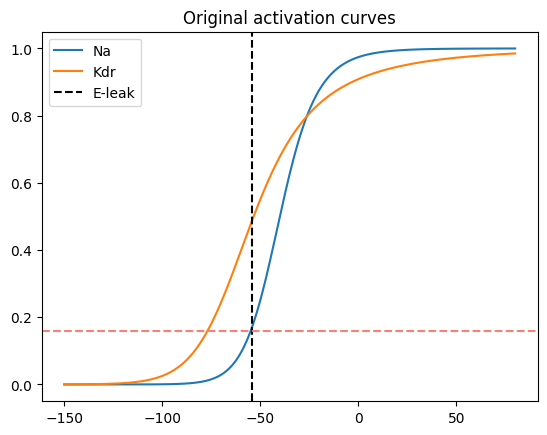

In [5]:
# From ACT/data/Spiker/orig/modfiles/hh.mod
def vtrap(x,y):
    if np.any(np.abs(x/y) < 1e-6):
        vtrap = y * (1 - x/y/2)
    else:
        vtrap = x / (np.exp(x/y) - 1)
    return vtrap

def Na(v):
    aNa = 0.1 * vtrap(-(v + 40), 10)
    bNa =  4 * np.exp(-(v + 65) / 18)
    return aNa / (aNa + bNa)

def Kdr(v):
    aK = 0.01 * vtrap(-(v + 55),10)
    bK = 0.125 * np.exp(-(v + 65) / 80)
    return aK / (aK + bK)

v = np.linspace(-150, 80, 1000)

plt.plot(v, Na(v), label = 'Na')
plt.plot(v, Kdr(v), label = 'Kdr')
plt.title("Original activation curves")
plt.axvline(-54.3, color = 'black', ls = '--', label = "E-leak")
plt.axhline(0.16, color = 'salmon', ls = '--')
plt.legend()

The segregation procedure above is implemented in `ACTSegregator`. It outputs segregated activation functions together with text to update the modfiles (the text includes cutoff and extrapolation voltages and line parameters).

In [ ]:
segregator = ACTSegregator()
seg_Na, seg_Kdr = segregator.segregate(v, [Na(v), Kdr(v)])

Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v < -75.017) {
        replace_with_var_name = 0.008 * v + 0.58
        }
        if (v < -77.017) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 1:

        :Segregation
        if (v < -75.017) {
        replace_with_var_name = 0.089 * v + 6.892
        }
        if (v < -77.017) {
        replace_with_var_name = 0
        }
        


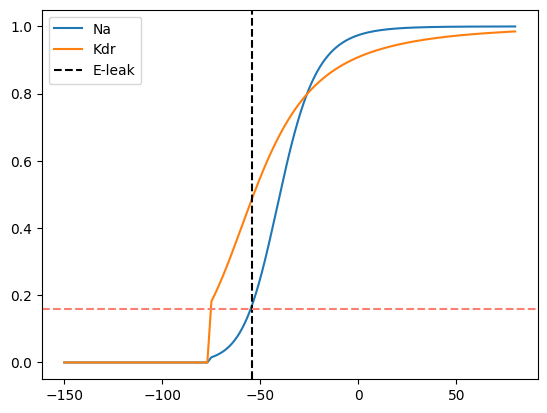

In [ ]:
plt.plot(v, seg_Na, label = 'Na')
plt.plot(v, seg_Kdr, label = 'Kdr')
plt.title("Segregated activation curves")
plt.axvline(-54.3, color = 'black', ls = '--', label = "E-leak")
plt.axhline(0.16, color = 'salmon', ls = '--')
plt.legend()

**Step 4.** Make a copy of the original folder with simulation templates and modfiles and name it `seg`. Update the modfile with the segregator's output. Now we simulate the original and segregated cells.

In [6]:
orig_cell = ACTCellModel(
    path_to_hoc_file = "/content/ACT/data/Spiker/orig/template.hoc",
    path_to_modfiles = "/content/ACT/data/Spiker/orig/modfiles",
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
    passive_properties = PassiveProperties(g_leak = "gl"),
    cell_name = "Spiker"
)

simulator = ACTSimulator(output_folder_name = "output")
simulator.submit_job(orig_cell, SimulationParameters(sim_name = "spiker_orig", sim_idx = 1, h_celsius = 6.3, CI = CurrentInjection(type = "constant", amp = 0.1)))
simulator.run_jobs(1)


        ACTSimulator (2024)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


In [7]:
seg_cell = ACTCellModel(
    path_to_hoc_file = "/content/ACT/data/Spiker/seg/template.hoc",
    path_to_modfiles = "/content/ACT/data/Spiker/seg/modfiles",
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
    passive_properties = PassiveProperties(g_leak = "gl"),
    cell_name = "Spiker"
)

simulator.submit_job(seg_cell, SimulationParameters(sim_name = "spiker_seg", sim_idx = 2, h_celsius = 6.3, CI = CurrentInjection(type = "constant", amp = 0.1)))
simulator.run_jobs(1)

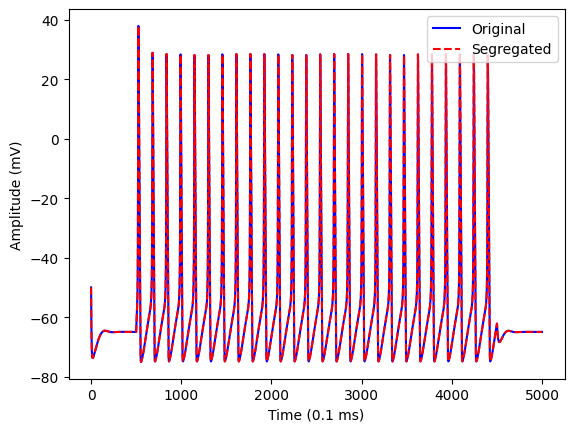

In [8]:
orig_out = np.load("output/spiker_orig/out_1.npy")
seg_out = np.load("output/spiker_seg/out_2.npy")

plt.plot(orig_out[:, 0], label = "Original", c = 'blue')
plt.plot(seg_out[:, 0], label = "Segregated", ls = '--', c = 'red')
plt.ylabel("Amplitude (mV)")
plt.xlabel("Time (0.1 ms)")
plt.legend()

### BursterCa

Ca-based burster.

Parameters (original / segregated where changed):
- eleak = -50
- gbar_leak = 4e-05
- gbar_na = 0.13 / 0.12
- gbar_kdr = 0.1 / 0.2
- gbar_cas = 0.01
- gbar_ka = 0.17 / 0.11
- gbar_cat = 0.005

Modules:
- Bursting: [gbar_cas, gbar_ka, gbar_cat], (-46.627; +inf)
- Spiking: [gnabar, gkbar], (-34.424; +inf)

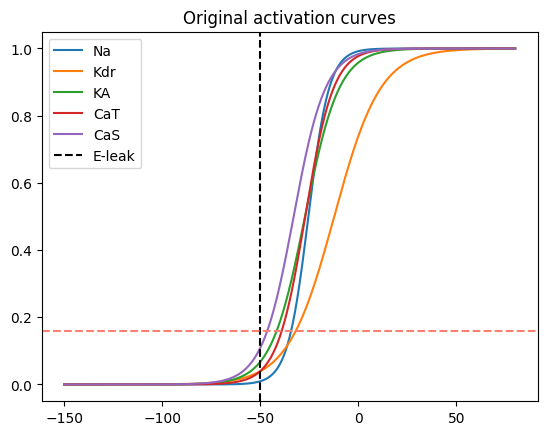

In [6]:
def Na(v):
    return 1.0/(1.0+ (np.exp((v+25.5)/(-5.29))))

def Kdr(v):
    return 1.0/(1.0 + (np.exp((v+12.3)/(-11.8))))

def KA(v):
    return 1.0/(1.0+(np.exp((v+27.2)/(-8.7))))

def CaT(v):
    return 1.0/(1.0+ (np.exp((v+27.1)/(-7.2))))

def CaS(v):
    return (1.0)/(1+ (np.exp((v+33.0)/(-8.1))))

v = np.linspace(-150, 80, 1000)

for func, func_name in zip([Na, Kdr, KA, CaT, CaS], ["Na", "Kdr", "KA", "CaT", "CaS"]):
    plt.plot(v, func(v), label = func_name)

plt.title("Original activation curves")
plt.axvline(-50, color = 'black', ls = '--', label = "E-leak")
plt.axhline(0.16, color = 'salmon', ls = '--')
plt.legend()

In [ ]:
segregator = ACTSegregator()
segregated_spiking = segregator.segregate(v, [Na(v), Kdr(v)])

Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v < -32.424) {
        replace_with_var_name = 0.104 * v + 3.575
        }
        if (v < -34.424) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 1:

        :Segregation
        if (v < -32.424) {
        replace_with_var_name = 0.076 * v + 2.617
        }
        if (v < -34.424) {
        replace_with_var_name = 0
        }
        


In [ ]:
segregated_bursting = segregator.segregate(v, [KA(v), CaT(v), CaS(v)])

Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v < -44.627) {
        replace_with_var_name = 0.058 * v + 2.727
        }
        if (v < -46.627) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 1:

        :Segregation
        if (v < -44.627) {
        replace_with_var_name = 0.039 * v + 1.841
        }
        if (v < -46.627) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 2:

        :Segregation
        if (v < -44.627) {
        replace_with_var_name = 0.095 * v + 4.412
        }
        if (v < -46.627) {
        replace_with_var_name = 0
        }
        


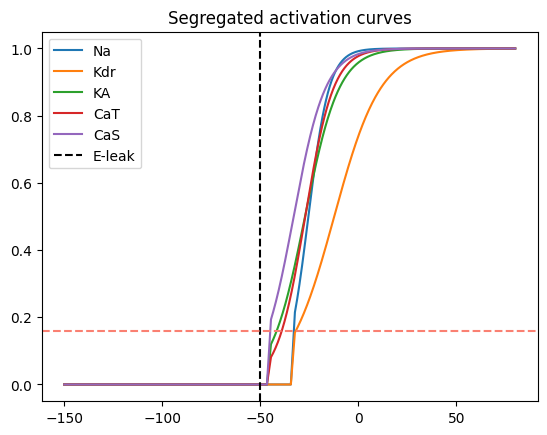

In [ ]:
for ac, ac_name in zip(segregated_spiking, ["Na", "Kdr"]):
    plt.plot(v, ac, label = ac_name)
for ac, ac_name in zip(segregated_bursting, ["KA", "CaT", "CaS"]):
    plt.plot(v, ac, label = ac_name)

plt.title("Segregated activation curves")
plt.axvline(-50, color = 'black', ls = '--', label = "E-leak")
plt.axhline(0.16, color = 'salmon', ls = '--')
plt.legend()

In [7]:
orig_cell = ACTCellModel(
    path_to_hoc_file = "/content/ACT/data/BursterCa/orig/template.hoc",
    path_to_modfiles = "/content/ACT/data/BursterCa/orig/modfiles",
    active_channels = ["gbar_na", "gbar_kdr", "gbar_ka", "gbar_cat", "gbar_cas"],
    passive_properties = PassiveProperties(g_leak = "gbar_leak"),
    cell_name = "BursterCa"
)

simulator = ACTSimulator(output_folder_name = "output")
simulator.submit_job(orig_cell, SimulationParameters(sim_name = "burster_orig", sim_idx = 1, h_celsius = 37, CI = CurrentInjection(type = "constant", amp = 0.1)))
simulator.run_jobs(1)


        ACTSimulator (2024)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


In [8]:
seg_cell = ACTCellModel(
    path_to_hoc_file = "/content/ACT/data/BursterCa/seg/template.hoc",
    path_to_modfiles = "/content/ACT/data/BursterCa/seg/modfiles",
    active_channels = ["gbar_na", "gbar_kdr", "gbar_ka", "gbar_cat", "gbar_cas"],
    passive_properties = PassiveProperties(g_leak = "gbar_leak"),
    cell_name = "BursterCa"
)

simulator = ACTSimulator(output_folder_name = "output")
simulator.submit_job(seg_cell, SimulationParameters(sim_name = "burster_seg", sim_idx = 1, h_celsius = 37, CI = CurrentInjection(type = "constant", amp = 0.1)))
simulator.run_jobs(1)


        ACTSimulator (2024)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


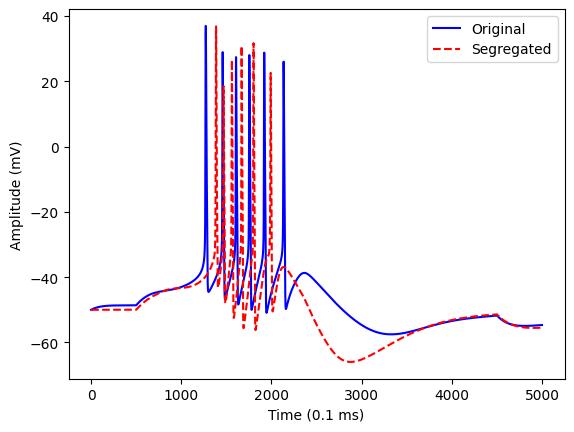

In [9]:
orig_out = np.load("output/burster_orig/out_1.npy")
seg_out = np.load("output/burster_seg/out_1.npy")

plt.plot(orig_out[:, 0], label = "Original", c = 'blue')
plt.plot(seg_out[:, 0], label = "Segregated", ls = '--', c = 'red')
plt.ylabel("Amplitude (mV)")
plt.xlabel("Time (0.1 ms)")
plt.legend()

### L5 Cell (Hay et al., 2011)

Neocortical Layer 5b Pyramidal Cell.

Parameters (original / segregated where changed):
- e_pas = -90
- g_pas = 0.0000338
- gIhbar_Ih = 0.0002
- gCa_LVAstbar_Ca_LVAst = 0.00343 
- gCa_HVAbar_Ca_HVA = 0.000992 
- gSKv3_1bar_SKv3_1 = 0.693
- gK_Tstbar_K_Tst = 0.0812
- gK_Pstbar_K_Pst = 0.00223
- gNap_Et2bar_Nap_Et2 = 0.00172 
- gNaTa_tbar_NaTa_t = 2.04

Modules:
- Passive: [gIhbar_Ih], (-inf; -60.44)
- Bursting: [gNap_Et2bar_Nap_Et2, gCa_LVAstbar_Ca_LVAst], (-60.44; +inf)
- Spiking: [gCa_HVAbar_Ca_HVA, gSKv3_1bar_SKv3_1, gK_Tstbar_K_Tst, gK_Pstbar_K_Pst, gNaTa_tbar_NaTa_t], (-44.324, +inf)

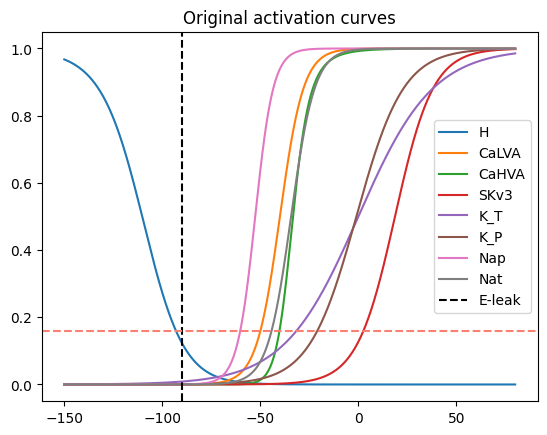

In [2]:
def H(v):
    mAlpha = 0.001*6.43*(v+154.9)/(np.exp((v+154.9)/11.9)-1)
    mBeta = 0.001*193*np.exp(v/33.1)
    return mAlpha/(mAlpha + mBeta)

def CaLVA(v):
    v = v + 10
    return 1.0000/(1+ np.exp((v - -30.000)/-6))

def CaHVA(v):
    mAlpha =  (0.055*(-27-v))/(np.exp((-27-v)/3.8) - 1)
    mBeta  =  (0.94*np.exp((-75-v)/17))
    return mAlpha/(mAlpha + mBeta)

def SKv3(v): # Shaw-related potassium channel
    return 1/(1+np.exp(((v -(18.700))/(-9.700))))

def K_T(v): # Transient potassium
    return 1/(1 + np.exp(-(v+0)/19))

def K_P(v): # Persistent potassium
    return (1/(1 + np.exp(-(v+1)/12)))

def Nap(v):
    return 1.0/(1+np.exp((v- -52.6)/-4.6))

def Nat(v):
    mAlpha = (0.182 * (v- -32))/(1-(np.exp(-(v- -32)/6)))
    mBeta  = (0.124 * (-v -32))/(1-(np.exp(-(-v -32)/6)))
    return mAlpha/(mAlpha + mBeta)

v = np.linspace(-150, 80, 1000)

for func, func_name in zip([H, CaLVA, CaHVA, SKv3, K_T, K_P, Nap, Nat], ["H", "CaLVA", "CaHVA", "SKv3", "K_T", "K_P", "Nap", "Nat"]):
    plt.plot(v, func(v), label = func_name)

plt.title("Original activation curves")
plt.axvline(-90, color = 'black', ls = '--', label = "E-leak")
plt.axhline(0.16, color = 'salmon', ls = '--')
plt.legend()

In [3]:
segregator = ACTSegregator()
segregated_spiking = segregator.segregate(v, [CaHVA(v), SKv3(v), K_T(v), K_P(v), Nat(v)])
segregated_bursting = segregator.segregate(v, [Nap(v), CaLVA(v)])

Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v < -42.324) {
        replace_with_var_name = 0.048 * v + 2.126
        }
        if (v < -44.324) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 1:

        :Segregation
        if (v < -42.324) {
        replace_with_var_name = 0.001 * v + 0.04
        }
        if (v < -44.324) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 2:

        :Segregation
        if (v < -42.324) {
        replace_with_var_name = 0.048 * v + 2.14
        }
        if (v < -44.324) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 3:

        :Segregation
        if (v < -42.324) {
        replace_with_var_name = 0.015 * v + 0.677
        }
        if (v < -44.324) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 4:

        :Segregation
        if (v < -42.324) {
  

In [4]:
segregated_passive = segregator.segregate(v, [H(v)], p_cutoff = 0.0069, on_the_right = False)

Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v > -62.21) {
        replace_with_var_name = -0.004 * v + -0.246
        }
        if (v > -60.21) {
        replace_with_var_name = 0
        }
        


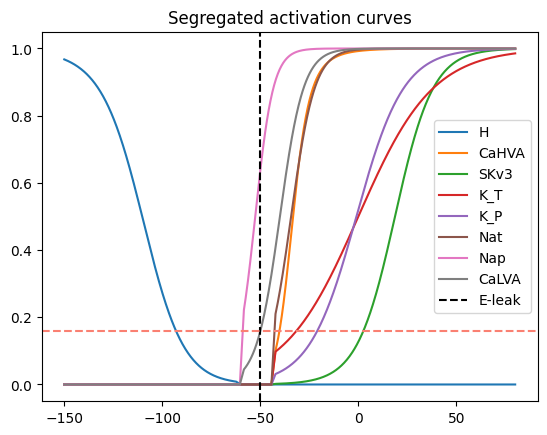

In [5]:
for ac, ac_name in zip(segregated_passive, ["H"]):
    plt.plot(v, ac, label = ac_name)

for ac, ac_name in zip(segregated_spiking, ["CaHVA", "SKv3", "K_T", "K_P", "Nat"]):
    plt.plot(v, ac, label = ac_name)

for ac, ac_name in zip(segregated_bursting, ["Nap", "CaLVA"]):
    plt.plot(v, ac, label = ac_name)

plt.title("Segregated activation curves")
plt.axvline(-50, color = 'black', ls = '--', label = "E-leak")
plt.axhline(0.16, color = 'salmon', ls = '--')
plt.legend()

In [2]:
import sys
sys.path.append("/Users/vladimiromelyusik/ACT/data/L5")

# 3D morphology builder for the L5 cell
from cell_builder import L5cellbuilder

In [3]:
orig_cell = ACTCellModel(
    path_to_hoc_file = "/Users/vladimiromelyusik/ACT/data/L5/orig/L5PCtemplate.hoc",
    path_to_mod_files = "/Users/vladimiromelyusik/ACT/data/L5/orig/modfiles",
    active_channels = [
        "gCa_LVAstbar_Ca_LVAst", 
        "gCa_HVAbar_Ca_HVA", 
        "gSKv3_1bar_SKv3_1", 
        "gK_Tstbar_K_Tst", 
        "gK_Pstbar_K_Pst", 
        "gNap_Et2bar_Nap_Et2", 
        "gNaTa_tbar_NaTa_t"], # Soma-only for now
    passive_properties = PassiveProperties(leak_conductance_variable = "g_pas"),
    cell_name = "L5PCtemplate"
)

# Set the builder
orig_cell.set_custom_cell_builder(L5cellbuilder)

simulator = ACTSimulator(output_folder_name = "output")
simulator.submit_job(orig_cell, SimulationParameters(sim_name = "L5_orig", sim_idx = 1, h_celsius = 37, CI = [CurrentInjection(type = "constant", amp = 2)]))
simulator.run_jobs(1)


        ACTSimulator (2024)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
Skipping analytical setting of e_leak variable. V_rest and/or leak_reversal_variable not specified.
Skipping analytical setting of g_bar_leak variable. g_bar_leak, leak_conductance_variable, R_in, and/or cell_area not specified.
Skipping analytical setting of cm. Cm, R_in and/or tau not specified.
Skipping analytical setting of e_leak variable. V_rest and/or leak_reversal_variable not specified.
Skipping analytical setting of g_bar_leak variable. g_bar_leak, leak_conductance_variable, R_in, and/or cell_area not specified.
Skipping analytical setting of cm. Cm, R_in and/or tau not specified.
Skipping analytical setting of e_leak variable. V_rest and/or leak_reversal_variable not specified.
Skipping analytical setting of g_bar_leak variable. g_bar_leak, leak_conductance_variable, R_in, and/or cell_area not specified.
Skipping analytical setting of cm. C

In [4]:
seg_cell = ACTCellModel(
    path_to_hoc_file = "/Users/vladimiromelyusik/ACT/data/L5/seg/L5PCtemplate.hoc",
    path_to_mod_files = "/Users/vladimiromelyusik/ACT/data/L5/seg/modfiles",
    active_channels = [
        "gCa_LVAstbar_Ca_LVAst", 
        "gCa_HVAbar_Ca_HVA", 
        "gSKv3_1bar_SKv3_1", 
        "gK_Tstbar_K_Tst", 
        "gK_Pstbar_K_Pst", 
        "gNap_Et2bar_Nap_Et2", 
        "gNaTa_tbar_NaTa_t"], # Soma-only for now
    passive_properties = PassiveProperties(leak_conductance_variable = "g_pas"),
    cell_name = "L5PCtemplate"
)

# Set the builder
seg_cell.set_custom_cell_builder(L5cellbuilder)

simulator = ACTSimulator(output_folder_name = "output")
simulator.submit_job(seg_cell, SimulationParameters(sim_name = "L5_seg", sim_idx = 1, h_celsius = 37, CI = [CurrentInjection(type = "constant", amp = 2)]))
simulator.run_jobs(1)


        ACTSimulator (2024)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
Skipping analytical setting of e_leak variable. V_rest and/or leak_reversal_variable not specified.
Skipping analytical setting of g_bar_leak variable. g_bar_leak, leak_conductance_variable, R_in, and/or cell_area not specified.
Skipping analytical setting of cm. Cm, R_in and/or tau not specified.
Skipping analytical setting of e_leak variable. V_rest and/or leak_reversal_variable not specified.
Skipping analytical setting of g_bar_leak variable. g_bar_leak, leak_conductance_variable, R_in, and/or cell_area not specified.
Skipping analytical setting of cm. Cm, R_in and/or tau not specified.
Skipping analytical setting of e_leak variable. V_rest and/or leak_reversal_variable not specified.
Skipping analytical setting of g_bar_leak variable. g_bar_leak, leak_conductance_variable, R_in, and/or cell_area not specified.
Skipping analytical setting of cm. C

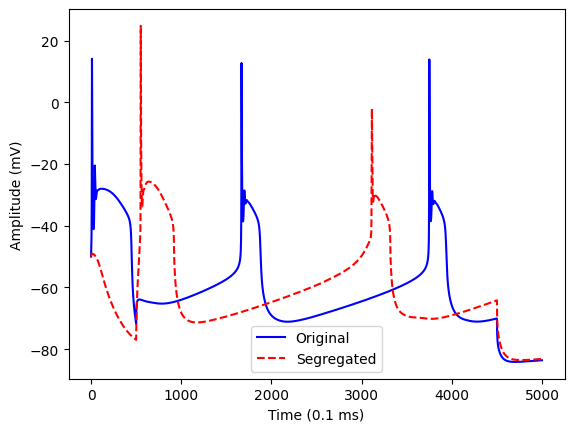

In [6]:
orig_out = np.load("output/L5_orig/out_1.npy")
seg_out = np.load("output/L5_seg/out_1.npy")

plt.plot(orig_out, label = "Original", c = 'blue')
plt.plot(seg_out, label = "Segregated", ls = '--', c = 'red')
plt.ylabel("Amplitude (mV)")
plt.xlabel("Time (0.1 ms)")
plt.legend()

### SST Cell (Allen Database)

Layer 2/3 cell from mouse primary visual area.

Parameters (original / segregated where changed):
- e_pas = -79.65586853027344
- g_pas = 0.00093621306427329868
- gbar_Ih = 0.0017877435830761807
- gbar_Ca_LVA = 0.0026048268426586809 
- gbar_Ca_HVA = 0.00088146780066759075 
- gbar_K_T = 0.007838697435023162
- gbar_Kd = 8.9038380401279538e-11 
- gbar_Kv2like = 0.00027257907728697739
- gbar_Kv3_1 = 0.10521580755926842
- gbar_Im_v2 = 2.8103810231817594e-07

Modules:
- Passive: [], ()
- Spiking: [], ()

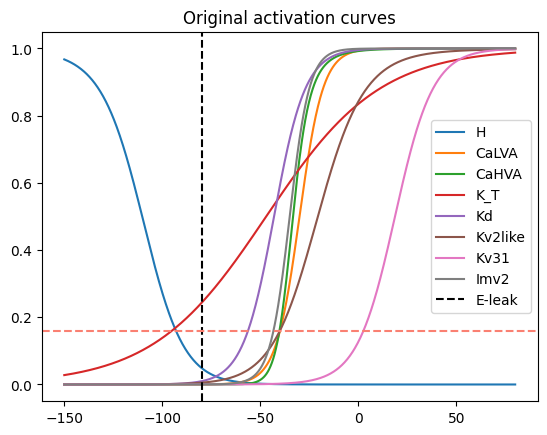

In [2]:
def vtrap(x, y):
    if np.any(np.abs(x / y) < 1e-6):
        return y * (1 - x / y / 2)
    else:
        return x / (np.exp(x / y) - 1)

def H(v):
    mAlpha = 0.001 * 6.43 * vtrap(v + 154.9, 11.9)
    mBeta  =  0.001*193*np.exp(v/33.1)
    return mAlpha/(mAlpha + mBeta)

def CaLVA(v):
    return 1.0000/(1+ np.exp((v - -30.000)/-6))

def CaHVA(v):
    mAlpha = 0.055 * vtrap(-27 - v, 3.8)
    mBeta  =  (0.94*np.exp((-75-v)/17))
    return mAlpha/(mAlpha + mBeta)

def K_T(v): # Transient potassium
    return 1/(1 + np.exp(-(v - (-47 + 0)) / 29))

def Kd(v):
    return 1 - 1 / (1 + np.exp((v - (-43)) / 8))

def Kv2like(v):
    mAlpha = 0.12 * vtrap( -(v - 43), 11.0)
    mBeta = 0.02 * np.exp(-(v + 1.27) / 120)
    return mAlpha/(mAlpha + mBeta)

def Kv31(v):
    return 1/(1+np.exp(((v -(18.700 + 0))/(-9.700))))

def Imv2(v):
    mAlpha = 3.3e-3*np.exp(2.5*0.04*(v - -35))
    mBeta = 3.3e-3*np.exp(-2.5*0.04*(v - -35))
    return mAlpha/(mAlpha + mBeta)

v = np.linspace(-150, 80, 1000)

for func, func_name in zip([H, CaLVA, CaHVA, K_T, Kd, Kv2like, Kv31, Imv2], ["H", "CaLVA", "CaHVA", "K_T", "Kd", "Kv2like", "Kv31", "Imv2"]):
    plt.plot(v, func(v), label = func_name)

plt.title("Original activation curves")
plt.axvline(-79.65586853027344, color = 'black', ls = '--', label = "E-leak")
plt.axhline(0.16, color = 'salmon', ls = '--')
plt.legend()

In [3]:
segregator = ACTSegregator()
segregated_spiking = segregator.segregate(v, [Kv31(v)])
segregated_bursting = segregator.segregate(v, [CaLVA(v), CaHVA(v), K_T(v), Kd(v), Kv2like(v), Imv2(v)])
segregated_passive = segregator.segregate(v, [H(v)], p_cutoff = 0.19, on_the_right = False)

Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v < 4.412) {
        replace_with_var_name = 0.092 * v + -0.222
        }
        if (v < 2.412) {
        replace_with_var_name = 0
        }
        
Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v < -93.205) {
        replace_with_var_name = 0.0 * v + 0.001
        }
        if (v < -95.205) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 1:

        :Segregation
        if (v < -93.205) {
        replace_with_var_name = 0.0 * v + 0.0
        }
        if (v < -95.205) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 2:

        :Segregation
        if (v < -93.205) {
        replace_with_var_name = 0.084 * v + 8.005
        }
        if (v < -95.205) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 3:

        :Segregat

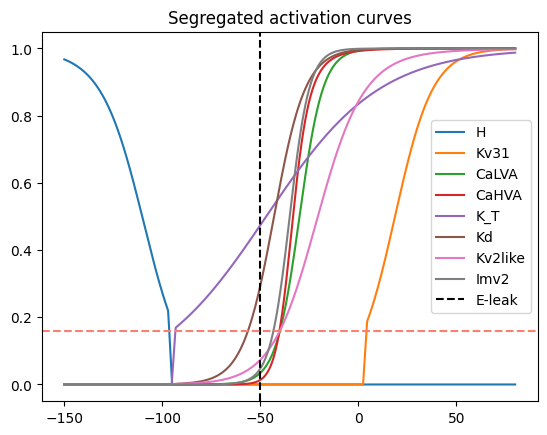

In [15]:
for ac, ac_name in zip(segregated_passive, ["H"]):
    plt.plot(v, ac, label = ac_name)

for ac, ac_name in zip(segregated_spiking, ["Kv31"]):
    plt.plot(v, ac, label = ac_name)

for ac, ac_name in zip(segregated_bursting, ["CaLVA", "CaHVA", "K_T", "Kd", "Kv2like", "Imv2"]):
    plt.plot(v, ac, label = ac_name)

plt.title("Segregated activation curves")
plt.axvline(-50, color = 'black', ls = '--', label = "E-leak")
plt.axhline(0.16, color = 'salmon', ls = '--')
plt.legend()

In [2]:
import sys
sys.path.append("/Users/vladimiromelyusik/ACT/data/SST")

# 3D morphology builder for the L5 cell
from cell_builder import SSTcellbuilder

In [3]:
orig_cell = ACTCellModel(
    path_to_hoc_file = None,
    path_to_mod_files = "/Users/vladimiromelyusik/ACT/data/SST/orig/modfiles",
    active_channels = [
        "gbar_Ca_LVA",
        "gbar_Ca_HVA",
        "gbar_K_T",
        "gbar_Kd",
        "gbar_Kv2like",
        "gbar_Kv3_1",
        "gbar_Im_v2"], # Soma-only for now
    passive_properties = PassiveProperties(leak_conductance_variable = "g_pas"),
    cell_name = None
)

# Set the builder
orig_cell.set_custom_cell_builder(SSTcellbuilder)

simulator = ACTSimulator(output_folder_name = "output")
simulator.submit_job(orig_cell, SimulationParameters(sim_name = "SST_orig", sim_idx = 1, h_celsius = 37, CI = [CurrentInjection(type = "constant", amp = 2)]))
simulator.run_jobs(1)


        ACTSimulator (2024)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 15144
  root at line 15156
  root at line 15211
  root at line 15318
  root at line 15496
  root at line 15811
  root at line 15857
  root at line 15883
  root at line 16161
  root at line 16200
  root at line 16210
  root at line 16253
  root at line 16286
  root at line 16301
  root at line 16326
  root at line 16574
  root at line 16613
  root at line 16618
  root at line 16645
  root at line 16695
  root at line 16751
  root at line 16765
  root at line 16768


In [3]:
seg_cell = ACTCellModel(
    path_to_hoc_file = None,
    path_to_mod_files = "/Users/vladimiromelyusik/ACT/data/SST/orig/modfiles",
    active_channels = [
        "gbar_Ca_LVA",
        "gbar_Ca_HVA",
        "gbar_K_T",
        "gbar_Kd",
        "gbar_Kv2like",
        "gbar_Kv3_1",
        "gbar_Im_v2"], # Soma-only for now
    passive_properties = PassiveProperties(leak_conductance_variable = "g_pas"),
    cell_name = None
)

# Set the builder
seg_cell.set_custom_cell_builder(SSTcellbuilder)

simulator = ACTSimulator(output_folder_name = "output")
simulator.submit_job(seg_cell, SimulationParameters(sim_name = "SST_seg", sim_idx = 1, h_celsius = 37, CI = [CurrentInjection(type = "constant", amp = 2)]))
simulator.run_jobs(1)


        ACTSimulator (2024)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 15144
  root at line 15156
  root at line 15211
  root at line 15318
  root at line 15496
  root at line 15811
  root at line 15857
  root at line 15883
  root at line 16161
  root at line 16200
  root at line 16210
  root at line 16253
  root at line 16286
  root at line 16301
  root at line 16326
  root at line 16574
  root at line 16613
  root at line 16618
  root at line 16645
  root at line 16695
  root at line 16751
  root at line 16765
  root at line 16768


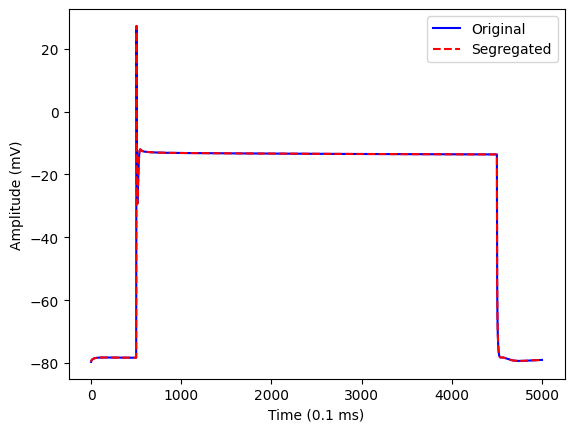

In [4]:
orig_out = np.load("output/SST_orig/out_1.npy")
seg_out = np.load("output/SST_orig/out_1.npy")

plt.plot(orig_out, label = "Original", c = 'blue')
plt.plot(seg_out, label = "Segregated", ls = '--', c = 'red')
plt.ylabel("Amplitude (mV)")
plt.xlabel("Time (0.1 ms)")
plt.legend()